In [1]:
import numpy as np
import pandas as pd
from shutil import copyfile
# from astropy.cosmology import Planck13 as cosmo
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
from astropy.cosmology import z_at_value
import fsps
from matplotlib import gridspec
import matplotlib as mpl
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
import astropy.units as u
from sim_engine import Scale_model
from spec_tools import Source_present, Oldest_galaxy, Sig_int, Smooth, Rescale_sfh, \
    lbt_to_z, boot_to_posterior, age_to_z, Posterior_spec
from spec_stats import Smooth, Highest_density_region, Linear_fit
from spec_id import *
from spec_stats import Highest_density_region, Linear_fit
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from sim_engine import forward_model_grism

from bokeh.models import HoverTool, ColumnDataSource, OpenURL, TapTool, DataTable, TableColumn, \
    Label, BoxAnnotation, Band
from bokeh import palettes
from bokeh.plotting import figure,save
from bokeh.io import show, output_notebook, output_file
from bokeh.transform import linear_cmap
from bokeh.layouts import gridplot

import pickle
from spec_tools import Gen_SFH

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 


Couldn't `import tristars`.  Get it from https://github.com/gbrammer/tristars to enable improved blind astrometric matching with triangle asterisms.



In [2]:
alldb = pd.read_pickle('../dataframes/fitdb/allfits_1D.pkl')
sfdb = pd.read_pickle('../dataframes/fitdb/SFfits_1D.pkl')

inout = []
for i in alldb.index:
    IO = 'i'
    if alldb.field[i] == 'GND' and alldb.id[i] in sfdb.query('field == "GND"').id.values:
        IO = 'o' 
    if alldb.field[i] == 'GSD' and alldb.id[i] in sfdb.query('field == "GSD"').id.values:
        IO = 'o' 
    inout.append(IO)
    
alldb['inout'] = inout

Qdb = alldb.query('inout == "i" and t_50 > 0')

adb = pd.concat([Qdb, sfdb])
adb = adb.reset_index()
adb = adb.drop(columns='index')
Adb = adb.query('AGN != "AGN" and lmass > 10 and 0.7 < zgrism < 2.5')

from scipy.optimize import curve_fit

def gauss(x,mu,sigma,A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

y,x=np.histogram(Adb.log_ssfr.values,100)

x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

expected=(-12, 0.45, 12,-9.56, 0.649,25)
params,cov=curve_fit(bimodal,x,y,expected)
sigma=np.sqrt(np.diag(cov))

X = np.linspace(-14, -7, 10000)
Qdist = gauss(X,-11.53617247, 0.65205167, 11.39604618)
SFdist = gauss(X,  -9.41418374, 0.59120587, 26.03851874)

Qint = []
Sint = []
for i in range(len(X)):
    Qint.append(np.trapz(Qdist[i:i+2],X[i:i+2]))
    Sint.append(np.trapz(SFdist[i:i+2],X[i:i+2]))    

Fint = np.add(Qint, Sint)

SFprob = interp1d(X,Sint / Fint)

t_q = []
lSig = []
lRe = []
lZ = []
z50 = []
concen = []
SFR = []
sfprob = []
for i in adb.index:
    if adb.zgrism[i] < 0:
        adb.zgrism[i] = adb.zfit[i]

    if adb.sSFR_avg[i] > 0:
        adb.log_ssfr[i] = adb.sSFR_avg[i]
     
    t_q.append(adb.t_50[i] - adb.t_90[i])
    lSig.append(np.log10(adb.Sigma1[i]))
    lRe.append(np.log10(adb.Re[i]))
    lZ.append(np.log10(adb.Z[i]))
    z50.append(cosmo.lookback_time(adb.z_50[i]).value)
    concen.append(np.log10(adb.Sigma1[i] / (10**adb.lmass[i])))
    SFR.append(np.log10(10**adb.log_ssfr[i] * 10**adb.lmass[i]))
    sfprob.append(float(SFprob(adb.log_ssfr[i])))
    
adb['t_q'] = t_q
adb['log_Sigma1'] = lSig
adb['log_Re'] = lRe
adb['log_Z'] = lZ
adb['z50'] = z50
adb['concen'] = concen
adb['log_sfr'] = SFR
adb['sf_prob'] = sfprob
  
Adb = adb.query('AGN != "AGN" and lmass > 10 and concen < -0.4 and 0.7 < zgrism < 2.5')
Axdb = adb.query('AGN == "AGN" and lmass > 10 and concen < -0.4 and 0.7 < zgrism < 2.5')

qdb = Adb.query('log_ssfr < -11 and AGN != "AGN" and n_f < 3 and  -2.4 < concen < -0.5')
sfdb = Adb.query('log_ssfr > -11 and AGN != "AGN" and n_f < 3 and  -2.4 < concen < -0.5')
xqdb = adb.query('log_ssfr < -11 and AGN == "AGN" and n_f < 3 and  -2.4 < concen < -0.5')
xsdb = adb.query('log_ssfr > -11 and AGN == "AGN" and n_f < 3 and -2.4 < concen < -0.5')

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [3]:
CNdb = pd.read_pickle('../dataframes/galaxy_frames/massMetal_GND_full.pkl')
CSdb = pd.read_pickle('../dataframes/galaxy_frames/massMetal_GSD_full.pkl')

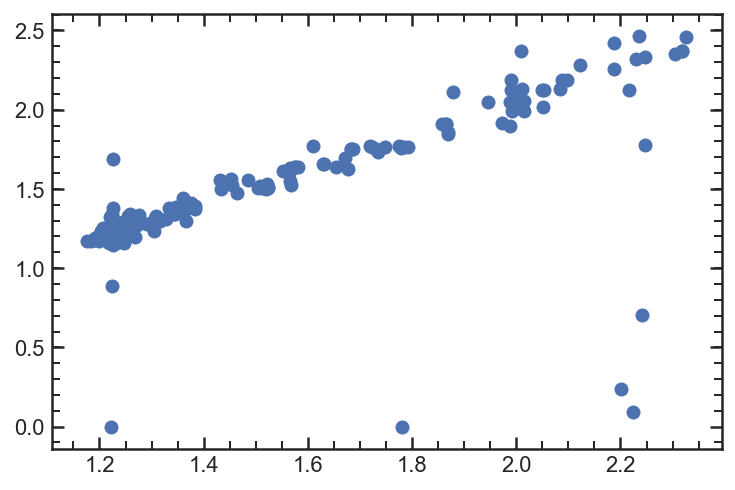

In [16]:
plt.scatter(CNdb.z_50,CNdb.z500 )

In [8]:
num = 0
for i in CNdb.index:
    if not CNdb.ID[i] in adb.query('field == "GND"').id.values:
        num +=1
        
for i in CSdb.index:
    if not CSdb.ID[i] in adb.query('field == "GSD"').id.values:
        num +=1
print(num)
print(len(CNdb) + len(CSdb))

181
269


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


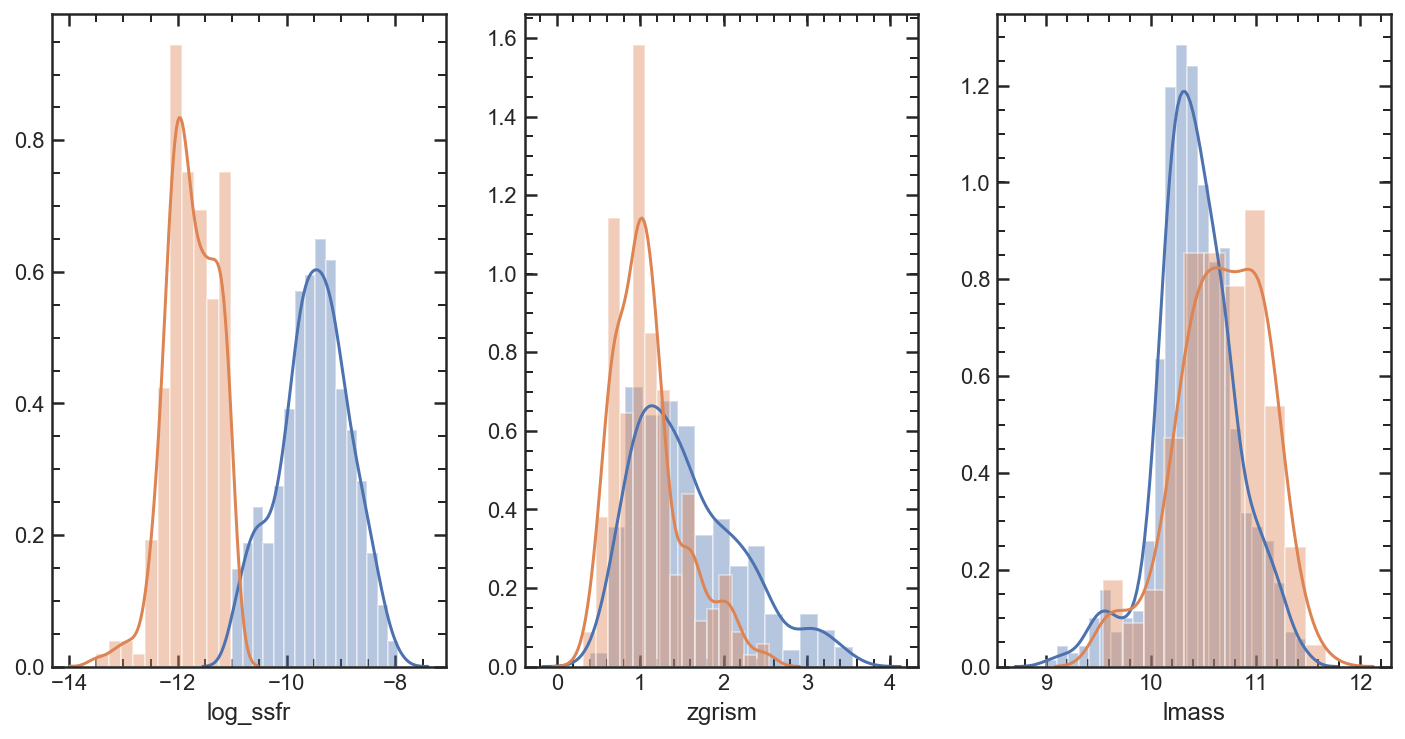

In [144]:
gs = gridspec.GridSpec(1,3)
plt.figure(figsize=[12,6])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])

sea.distplot(sfdb.log_ssfr,ax=ax1)
sea.distplot(qdb.log_ssfr,ax=ax1)

sea.distplot(sfdb.zgrism,ax=ax2)
sea.distplot(qdb.zgrism,ax=ax2)

sea.distplot(sfdb.lmass,ax=ax3)
sea.distplot(qdb.lmass,ax=ax3)

In [147]:
p = figure(plot_width=800, plot_height=500, title=None, x_axis_label ='lmass',
            y_axis_label = 'SFR',
            tools = "tap,pan,wheel_zoom,box_zoom,reset,lasso_select")
p.scatter(x=qdb.lmass, y=np.log10(10**qdb.log_ssfr*10**qdb.lmass),size=5, color="tomato", alpha=0.5,legend='quiescent')
p.scatter(x=sfdb.lmass, y=np.log10(10**sfdb.log_ssfr*10**sfdb.lmass),size=5, color="cadetblue", alpha=0.5,legend='star-forming')
p.scatter(x=xqdb.lmass, y=np.log10(10**xqdb.log_ssfr*10**xqdb.lmass),size=10, color="darkred", alpha=0.5, marker = 'x',legend='xray - Q')
p.scatter(x=xsdb.lmass, y=np.log10(10**xsdb.log_ssfr*10**xsdb.lmass),size=10, color="darkblue", alpha=0.5, marker = 'x',legend='xray - SF')

p.legend.location = "top_right"
p.legend.click_policy="hide"

p.xaxis.axis_label_text_font_size="12pt"
p.yaxis.axis_label_text_font_size="12pt"
p.xaxis.major_label_text_font_size="10pt"
p.yaxis.major_label_text_font_size="10pt"

output_notebook()
show(p)

Loading BokehJS ...

In [45]:
p = figure(plot_width=800, plot_height=500, title=None, x_axis_label ='redshift',
            y_axis_label = 't_50',
            tools = "tap,pan,wheel_zoom,box_zoom,reset,lasso_select")
p.scatter(x=qdb.zgrism, y=qdb.t_50,size=5, color="tomato", alpha=0.5,legend='quiescent')
p.scatter(x=sfdb.zgrism, y=sfdb.t_50,size=5, color="cadetblue", alpha=0.5,legend='star-forming')
p.scatter(x=xqdb.zgrism, y=xqdb.t_50,size=10, color="darkred", alpha=0.5, marker = 'x',legend='xray - Q')
p.scatter(x=xsdb.zgrism, y=xsdb.t_50,size=10, color="darkblue", alpha=0.5, marker = 'x',legend='xray - SF')

p.legend.location = "top_right"
p.legend.click_policy="hide"

p.xaxis.axis_label_text_font_size="12pt"
p.yaxis.axis_label_text_font_size="12pt"
p.xaxis.major_label_text_font_size="10pt"
p.yaxis.major_label_text_font_size="10pt"

output_notebook()
show(p)

Loading BokehJS ...

In [148]:
p = figure(plot_width=800, plot_height=500, title=None, x_axis_label ='log(Mass)',
            y_axis_label = 'log(Z)',
            tools = "tap,pan,wheel_zoom,box_zoom,reset,lasso_select")
p.scatter(x=np.log10(qdb.Sigma1), y=np.log10(qdb.Z),size=5, color="tomato", alpha=0.5,legend='quiescent')
p.scatter(x=np.log10(sfdb.Sigma1), y=np.log10(sfdb.Z),size=5, color="cadetblue", alpha=0.5,legend='star-forming')
p.scatter(x=np.log10(xqdb.Sigma1), y=np.log10(xqdb.Z),size=10, color="darkred", alpha=0.5, marker = 'x',legend='xray - Q')
p.scatter(x=np.log10(xsdb.Sigma1), y=np.log10(xsdb.Z),size=10, color="darkblue", alpha=0.5, marker = 'x',legend='xray - SF')

p.legend.location = "top_left"
p.legend.click_policy="hide"

p.xaxis.axis_label_text_font_size="12pt"
p.yaxis.axis_label_text_font_size="12pt"
p.xaxis.major_label_text_font_size="10pt"
p.yaxis.major_label_text_font_size="10pt"

output_notebook()
show(p)

Loading BokehJS ...

In [47]:
p = figure(plot_width=800, plot_height=500, title=None, x_axis_label ='redshift',
            y_axis_label = 't_q',
            tools = "tap,pan,wheel_zoom,box_zoom,reset,lasso_select")
p.scatter(x=qdb.zgrism, y=qdb.t_50 - qdb.t_90,size=5, color="tomato", alpha=0.5,legend='quiescent')
p.scatter(x=sfdb.zgrism, y=sfdb.t_50 - sfdb.t_90,size=5, color="cadetblue", alpha=0.5,legend='star-forming')
p.scatter(x=xqdb.zgrism, y=xqdb.t_50 - xqdb.t_90,size=10, color="darkred", alpha=0.5, marker = 'x',legend='xray - Q')
p.scatter(x=xsdb.zgrism, y=xsdb.t_50 - xsdb.t_90,size=10, color="darkblue", alpha=0.5, marker = 'x',legend='xray - SF')

p.legend.location = "top_right"
p.legend.click_policy="hide"

p.xaxis.axis_label_text_font_size="12pt"
p.yaxis.axis_label_text_font_size="12pt"
p.xaxis.major_label_text_font_size="10pt"
p.yaxis.major_label_text_font_size="10pt"

output_notebook()
show(p)

Loading BokehJS ...

In [110]:
p = figure(plot_width=800, plot_height=500, title=None, x_axis_label ='log(Sigma1)',
            y_axis_label = 'z_50',x_range=(8.,10.7),
            tools = "tap,pan,wheel_zoom,box_zoom,reset,lasso_select")
p.scatter(x=np.log10(qdb.Sigma1), y=cosmo.lookback_time(qdb.z_50).value,size=5, 
          color="tomato", alpha=0.5,legend='quiescent')
p.scatter(x=np.log10(sfdb.Sigma1), y=cosmo.lookback_time(sfdb.z_50).value,size=5, 
          color="cadetblue", alpha=0.5,legend='star-forming')
p.scatter(x=np.log10(xqdb.Sigma1), y=cosmo.lookback_time(xqdb.z_50).value,size=10, 
          color="darkred", alpha=0.5, marker = 'x',legend='xray - Q')
p.scatter(x=np.log10(xsdb.Sigma1), y=cosmo.lookback_time(xsdb.z_50).value,size=10, 
          color="darkblue", alpha=0.5, marker = 'x',legend='xray - SF')

p.legend.location = "top_left"
p.legend.click_policy="hide"

p.xaxis.axis_label_text_font_size="12pt"
p.yaxis.axis_label_text_font_size="12pt"
p.xaxis.major_label_text_font_size="10pt"
p.yaxis.major_label_text_font_size="10pt"
zs = cosmo.lookback_time([2,3,4,5,6,7]).value
p.yaxis.ticker = zs

p.yaxis.major_label_overrides = {zs[0]:'2',zs[1]:'3',zs[2]:'4',zs[3]:'5',zs[4]:'6',zs[5]:'7'}

output_notebook()
show(p)

Loading BokehJS ...

In [3]:
import yaml

from bokeh.layouts import column, gridplot, row
from bokeh.models import ColumnDataSource, Select
from bokeh.plotting import figure
from bokeh.themes import Theme
from bokeh.io import show, output_notebook

from bokeh.sampledata.sea_surface_temperature import sea_surface_temperature

output_notebook()

Loading BokehJS ...

In [4]:
zs = cosmo.lookback_time([2,3,4,5,6,7]).value

def PLOT(src_set, X_data, Y_data, xtitle, ytitle):
    plot = figure(plot_width=500, plot_height=400, title=None, x_axis_label =xtitle,
            y_axis_label = ytitle,
            tools = "tap,pan,wheel_zoom,box_zoom,reset,lasso_select")
    
    plot.scatter(x=X_data, y=Y_data, source=src_set[0],size=5,          
                 color="tomato", alpha=0.5,legend='quiescent')
    plot.scatter(x=X_data, y=Y_data, source=src_set[1], size=5,             
                 color="cadetblue", alpha=0.5,legend='star-forming')
    plot.scatter(x=X_data, y=Y_data, source=src_set[2], size=10,             
                 color="darkred", alpha=0.5, marker = 'x',legend='xray - Q')
    plot.scatter(x=X_data, y=Y_data, source=src_set[3], size=10,             
                 color="darkblue", alpha=0.5, marker = 'x',legend='xray - SF')
    plot.legend.click_policy="hide"
    return plot

def PLOT_z50(src_set, X_data, Y_data, xtitle, ytitle):
    plot = figure(plot_width=500, plot_height=400, title=None, x_axis_label =xtitle,
            y_axis_label = ytitle,
            tools = "tap,pan,wheel_zoom,box_zoom,reset,lasso_select")
    
    plot.scatter(x=X_data, y=Y_data, source=src_set[0],size=5,          
                 color="tomato", alpha=0.5,legend='quiescent')
    plot.scatter(x=X_data, y=Y_data, source=src_set[1], size=5,             
                 color="cadetblue", alpha=0.5,legend='star-forming')
    plot.scatter(x=X_data, y=Y_data, source=src_set[2], size=10,             
                 color="darkred", alpha=0.5, marker = 'x',legend='xray - Q')
    plot.scatter(x=X_data, y=Y_data, source=src_set[3], size=10,             
                 color="darkblue", alpha=0.5, marker = 'x',legend='xray - SF')
    plot.legend.click_policy="hide"
    
    if X_data == 'z50':
        plot.xaxis.ticker = zs
        plot.xaxis.major_label_overrides = {zs[0]:'2',zs[1]:'3',zs[2]:'4',zs[3]:'5',zs[4]:'6',zs[5]:'7'}
    if Y_data == 'z50':
        plot.yaxis.ticker = zs
        plot.yaxis.major_label_overrides = {zs[0]:'2',zs[1]:'3',zs[2]:'4',zs[3]:'5',zs[4]:'6',zs[5]:'7'}

    return plot

def bkapp(doc):
    
    def callback(attr, old, new):
#         if 'z50' in [menu1.value, menu2.value]:
#             plot1 = PLOT_z50([s1,s2,s3,s4], 'x1', 'y1', menu1.value, menu2.value)
#         else:
#             plot1 = PLOT([s1,s2,s3,s4], 'x1', 'y1', menu1.value, menu2.value)

#         if 'z50' in [menu3.value, menu4.value]:
#             print('here')
#             plot2 = PLOT_z50([s1,s2,s3,s4], 'x2', 'y2', menu3.value, menu4.value)
#         else:
#             print('skip')
#             plot2 = PLOT([s1,s2,s3,s4], 'x2', 'y2', menu3.value, menu4.value)
        
        
        plot1.xaxis.axis_label =  menu1.value
        plot1.yaxis.axis_label =  menu2.value
        plot2.xaxis.axis_label =  menu3.value
        plot2.yaxis.axis_label =  menu4.value
        
        plot1.legend.location = menu5.value
        plot2.legend.location = menu6.value
        
        s1.data={'x1': qdb[menu1.value], 'y1': qdb[menu2.value], 
                 'x2': qdb[menu3.value], 'y2': qdb[menu4.value]} 
        s2.data={'x1': sfdb[menu1.value], 'y1': sfdb[menu2.value],
                 'x2': sfdb[menu3.value], 'y2': sfdb[menu4.value]} 
        s3.data={'x1': xqdb[menu1.value], 'y1': xqdb[menu2.value], 
                 'x2': xqdb[menu3.value], 'y2': xqdb[menu4.value]} 
        s4.data={'x1': xsdb[menu1.value], 'y1': xsdb[menu2.value], 
                 'x2': xsdb[menu3.value], 'y2': xsdb[menu4.value]} 


        
        
        
    menu_options = ['Av', 'log_Sigma1', 'log_Re', 'log_Z', 'lmass', 'log_ssfr', 'lwa', 'n', 
    't_50', 't_80', 't_90', 'z50', 't_q', 'zgrism']
    
    menu1 = Select(options=menu_options,
     value='zgrism', title='X-value', width=120)
    menu1.on_change('value', callback) 
        
    menu2 = Select(options=menu_options,
     value='t_50', title='Y-value', width=120)
    menu2.on_change('value', callback)
      
    menu3 = Select(options=menu_options,
     value='lmass', title='X-value', width=120)
    menu3.on_change('value', callback) 
        
    menu4 = Select(options=menu_options,
     value='lwa', title='Y-value', width=120)
    menu4.on_change('value', callback)
    
    menu5 = Select(options=['top_right', 'top_left', 'bottom_right','bottom_left'],
     value='top_right', title='legend position', width=120)
    menu5.on_change('value', callback)
    
    menu6 = Select(options=['top_right', 'top_left', 'bottom_right','bottom_left'],
     value='top_right', title='legend position', width=120)
    menu6.on_change('value', callback)
    
    s1 = ColumnDataSource({'x1': qdb[menu1.value], 'y1': qdb[menu2.value], 
                 'x2': qdb[menu3.value], 'y2': qdb[menu4.value]})
    s2 = ColumnDataSource({'x1': sfdb[menu1.value], 'y1': sfdb[menu2.value],
                 'x2': sfdb[menu3.value], 'y2': sfdb[menu4.value]})
    s3 = ColumnDataSource({'x1': xqdb[menu1.value], 'y1': xqdb[menu2.value], 
                 'x2': xqdb[menu3.value], 'y2': xqdb[menu4.value]})
    s4 = ColumnDataSource({'x1': xsdb[menu1.value], 'y1': xsdb[menu2.value], 
                 'x2': xsdb[menu3.value], 'y2': xsdb[menu4.value]})
        
    plot1 = PLOT([s1,s2,s3,s4], 'x1', 'y1', menu1.value, menu2.value)
    plot2 = PLOT([s1,s2,s3,s4], 'x2', 'y2', menu3.value, menu4.value)
    
    doc.add_root(row(column(menu5, plot1, row(menu1,menu2)), 
                     column(menu6, plot2, row(menu3,menu4))))


In [5]:
# show(bkappnotebook_url="http://localhost:8888"

show(bkapp) # notebook_url="http://localhost:8888"


In [201]:
p = figure(plot_width=800, plot_height=500, title=None,
            tools = "tap,pan,wheel_zoom,box_zoom,reset,lasso_select")
p.scatter(x=qdb.query('0.8 < zgrism < 2.5  and n_f < 3').cmptc, 
          y=qdb.query('0.8 < zgrism < 2.5  and n_f < 3').log_Sigma1,size=5, color="tomato", alpha=0.5)
p.scatter(x=sfdb.query('0.8 < zgrism < 2.5  and n_f < 3').cmptc, 
          y=sfdb.query('0.8 < zgrism < 2.5  and n_f < 3').log_Sigma1,size=5, color="cadetblue", alpha=0.5)

p.xaxis.axis_label_text_font_size="12pt"
p.yaxis.axis_label_text_font_size="12pt"
p.xaxis.major_label_text_font_size="10pt"
p.yaxis.major_label_text_font_size="10pt"

output_notebook()
show(p)

Loading BokehJS ...

In [200]:
p = figure(plot_width=800, plot_height=500, title=None, 
            tools = "tap,pan,wheel_zoom,box_zoom,reset,lasso_select")
p.scatter(x=qdb.query('0.8 < zgrism < 2.5  and n_f < 3').lmass, 
          y=qdb.query('0.8 < zgrism < 2.5  and n_f < 3').z50,size=5, color="tomato", alpha=0.5)
p.scatter(x=sfdb.query('0.8 < zgrism < 2.5  and n_f < 3').lmass, 
          y=sfdb.query('0.8 < zgrism < 2.5  and n_f < 3').z50,size=5, color="cadetblue", alpha=0.5)
p.xaxis.axis_label_text_font_size="12pt"
p.yaxis.axis_label_text_font_size="12pt"
p.xaxis.major_label_text_font_size="10pt"
p.yaxis.major_label_text_font_size="10pt"

output_notebook()
show(p)

Loading BokehJS ...

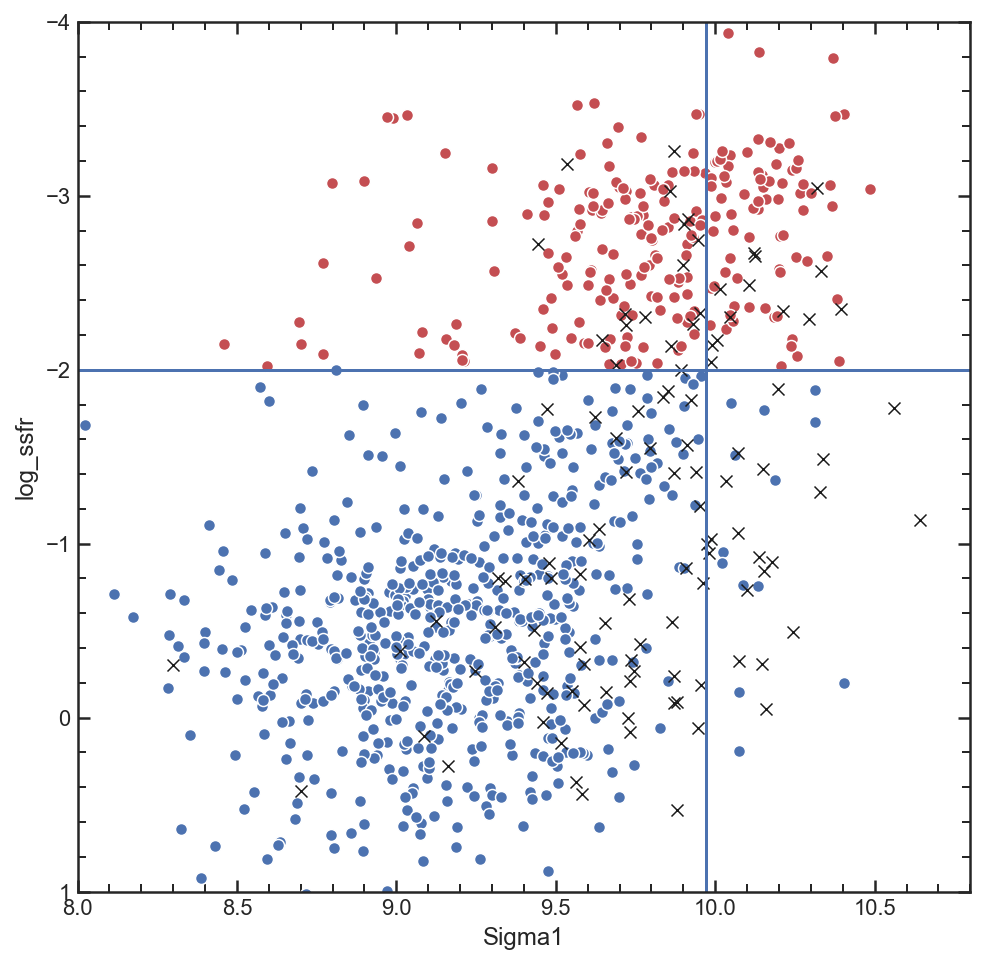

In [101]:
plt.figure(figsize=[8,8])
sea.scatterplot(np.log10(adb.query('AGN != "AGN" and log_ssfr < -11 and zgrism > 0').Sigma1),
                adb.query('AGN != "AGN" and log_ssfr < -11 and zgrism > 0').log_ssfr+9, color = 'r')
sea.scatterplot(np.log10(adb.query('AGN != "AGN" and log_ssfr > -11 and zgrism > 0').Sigma1),
                adb.query('AGN != "AGN" and log_ssfr > -11 and zgrism > 0').log_ssfr+9, color = 'b')
sea.scatterplot(np.log10(adb.query('AGN == "AGN" and zgrism > 0').Sigma1),
                adb.query('AGN == "AGN" and zgrism > 0').log_ssfr+9, color = 'k' ,marker = 'x')

plt.xlim(8,10.8)
plt.ylim(1,-4)
plt.axhline(-2)
plt.axvline(9.97)

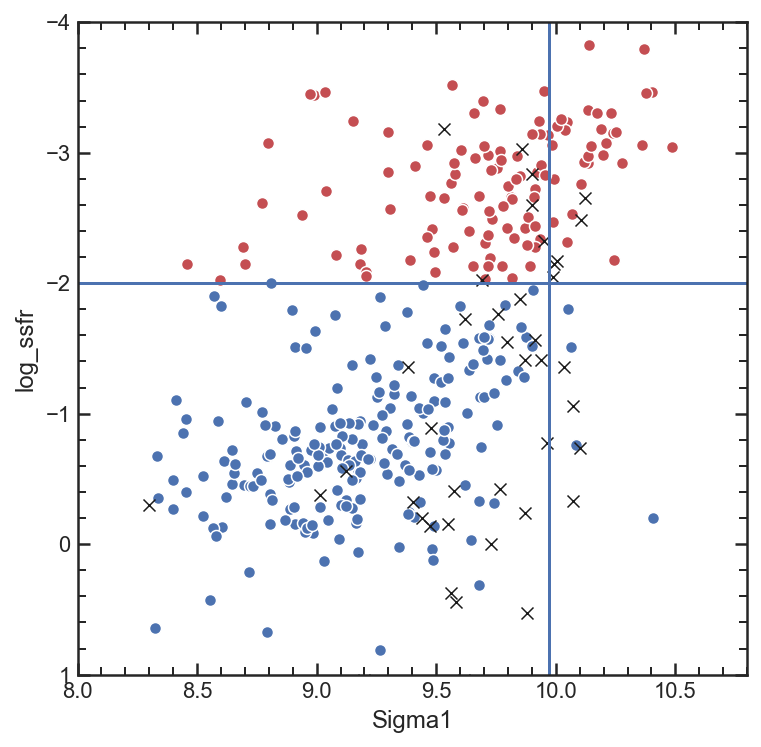

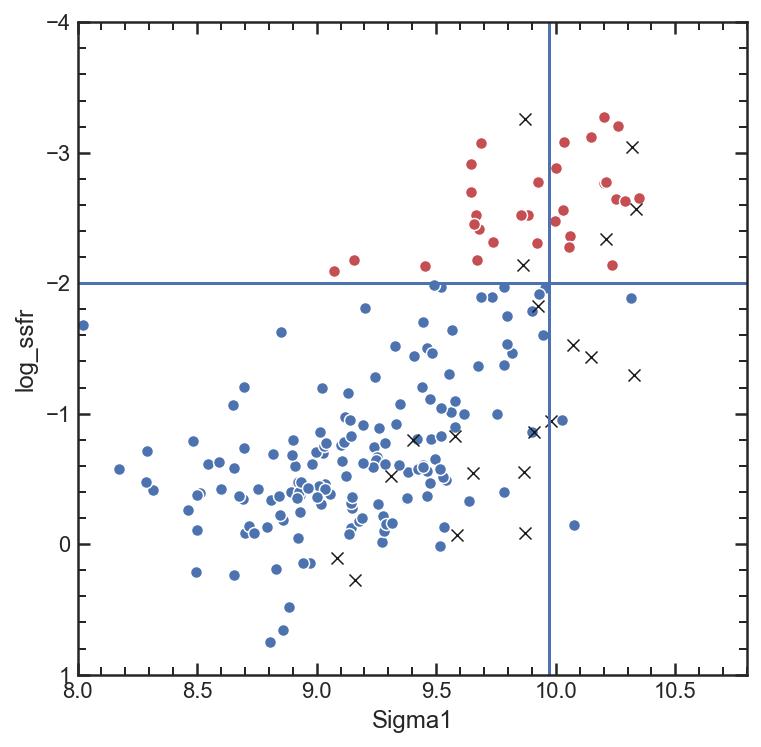

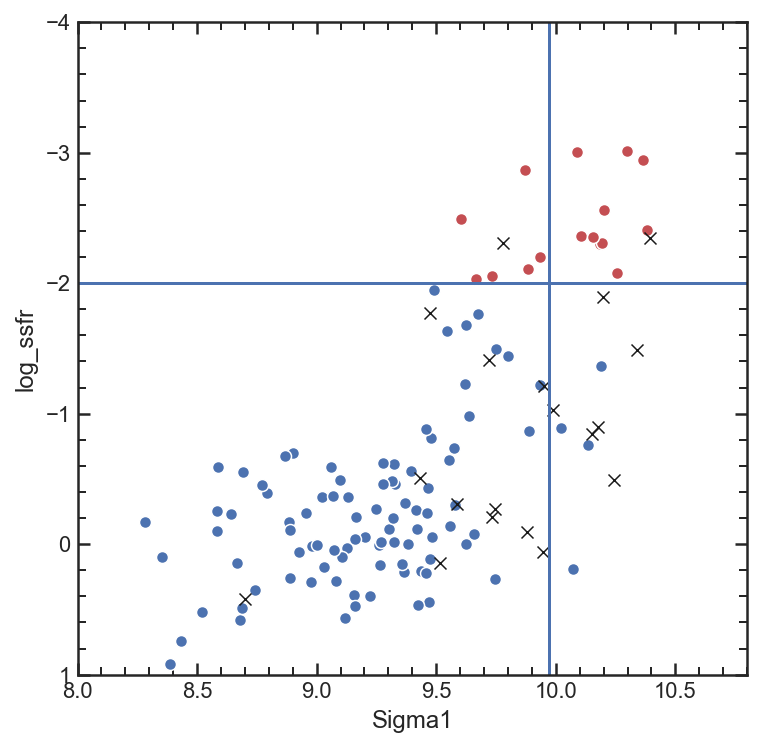

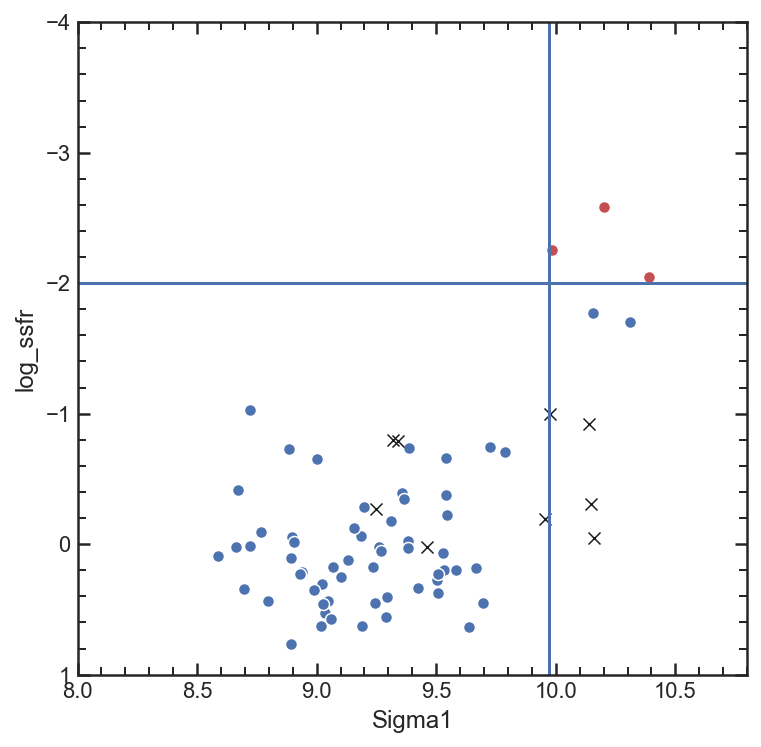

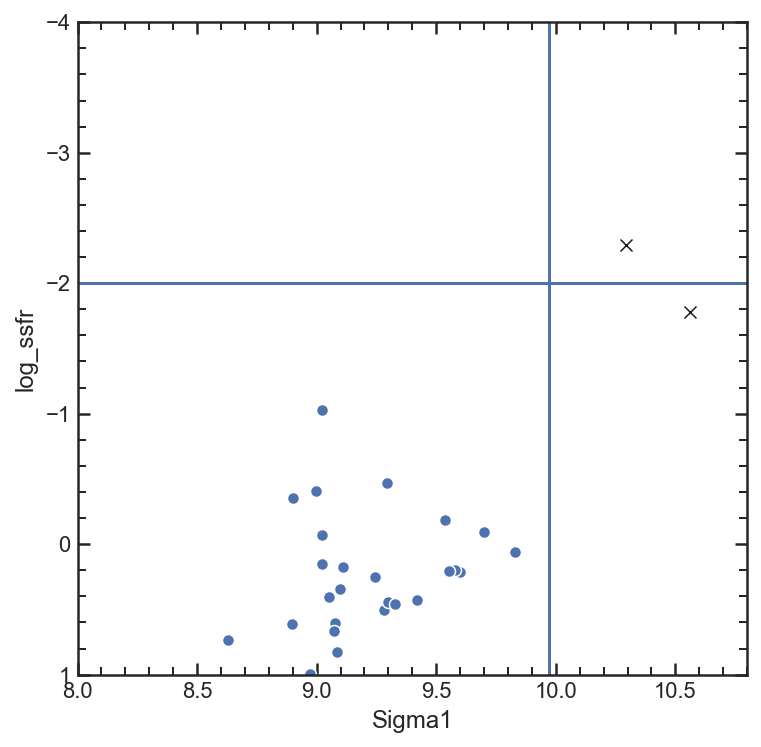

In [105]:
zlims = [0.8,1.3,1.8,2.3,2.8,3.2]

for i in range(len(zlims)-1):
    plt.figure(figsize=[6,6])
    sea.scatterplot(np.log10(adb.query('AGN != "AGN" and log_ssfr < -11 and {} < zgrism < {}'.format(zlims[i], zlims[i+1])).Sigma1),
                    adb.query('AGN != "AGN" and log_ssfr < -11 and {} < zgrism < {}'.format(zlims[i], zlims[i+1])).log_ssfr+9, color = 'r')
    sea.scatterplot(np.log10(adb.query('AGN != "AGN" and log_ssfr > -11 and {} < zgrism < {}'.format(zlims[i], zlims[i+1])).Sigma1),
                    adb.query('AGN != "AGN" and log_ssfr > -11 and {} < zgrism < {}'.format(zlims[i], zlims[i+1])).log_ssfr+9, color = 'b')
    sea.scatterplot(np.log10(adb.query('AGN == "AGN" and {} < zgrism < {}'.format(zlims[i], zlims[i+1])).Sigma1),
                    adb.query('AGN == "AGN" and {} < zgrism < {}'.format(zlims[i], zlims[i+1])).log_ssfr+9, color = 'k' ,marker = 'x')

    plt.xlim(8,10.8)
    plt.ylim(1,-4)
    plt.axhline(-2)
    plt.axvline(9.97)

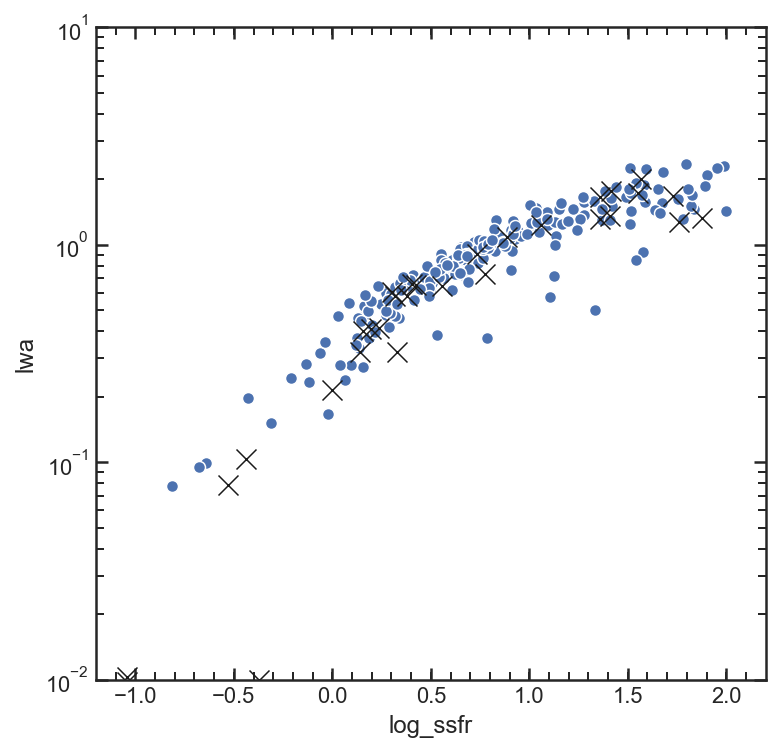

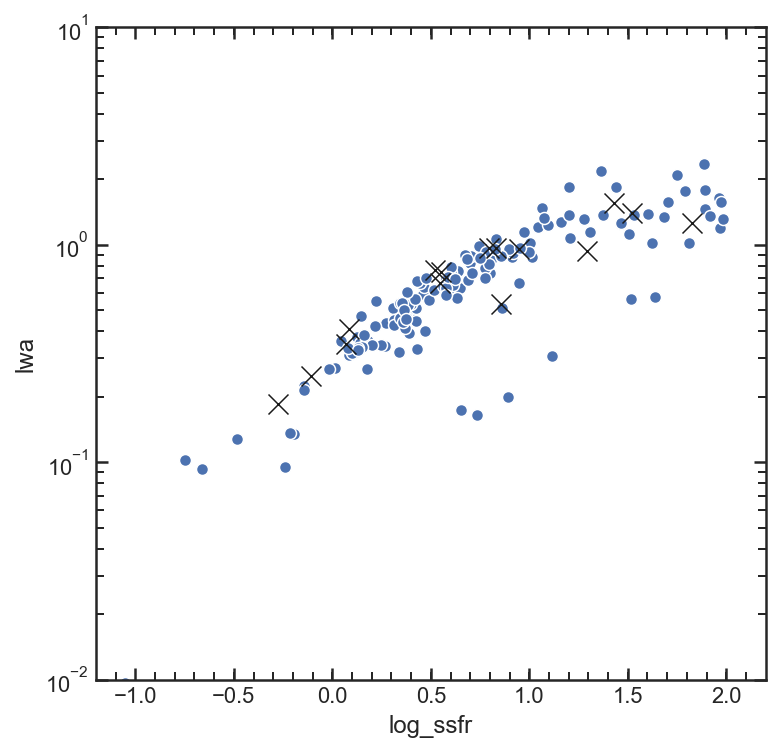

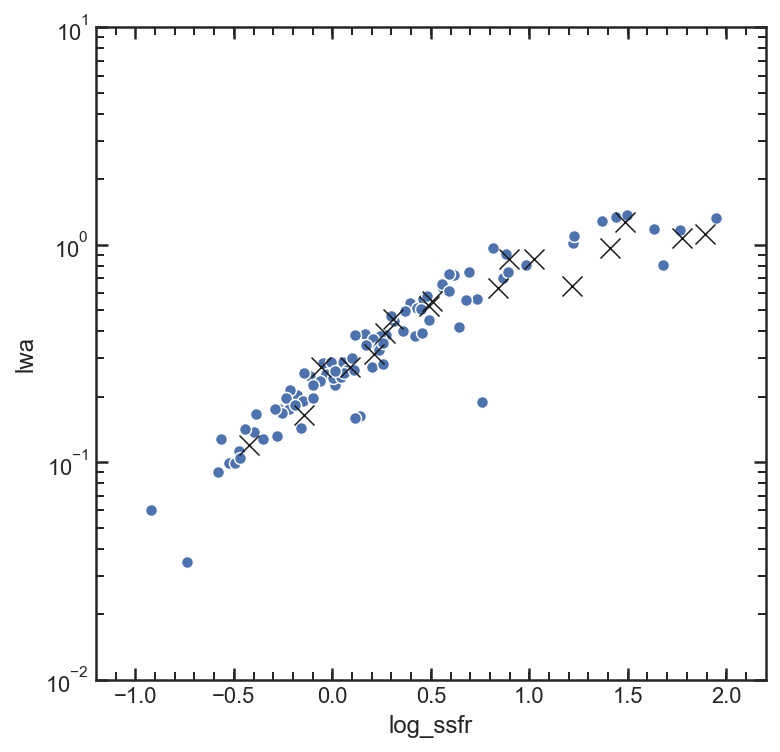

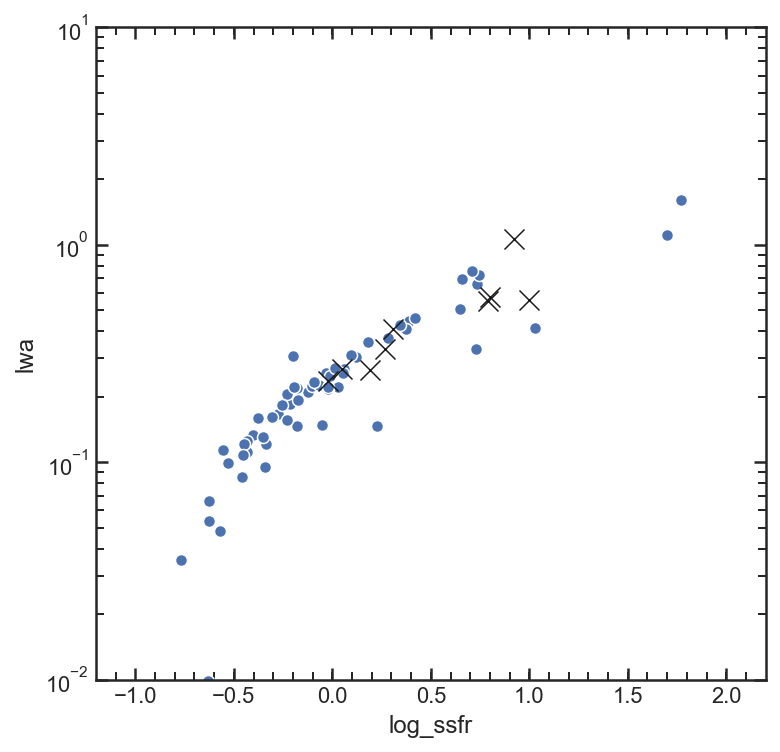

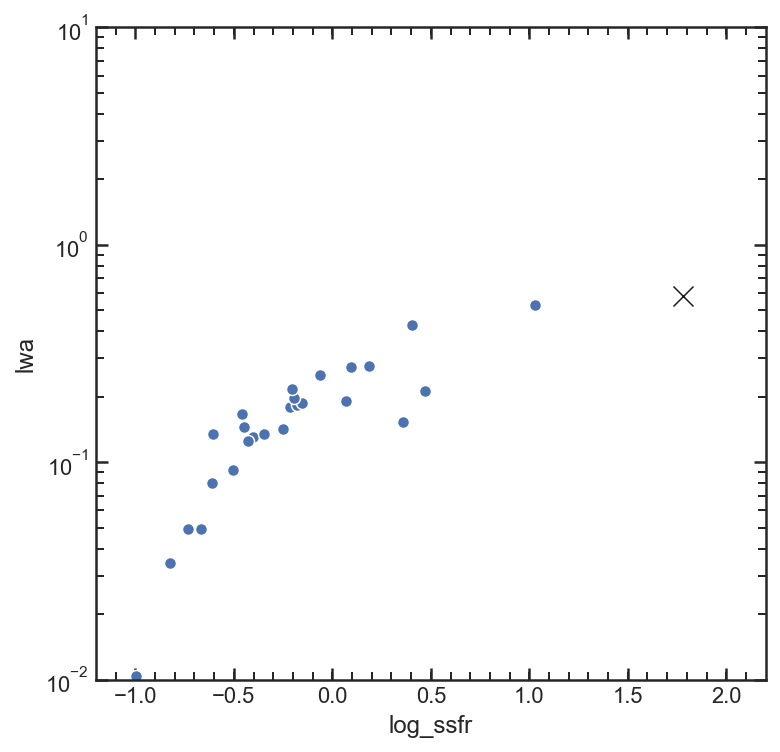

In [160]:
zlims = [0.8,1.3,1.8,2.3,2.8,3.2]

for i in range(len(zlims)-1):
#     plt.figure(figsize=[6,6])
#     sea.scatterplot(np.log10(adb.query('AGN != "AGN" and log_ssfr < -11 and {} < zgrism < {}'.format(zlims[i], zlims[i+1])).Sigma1),
#                     adb.query('AGN != "AGN" and log_ssfr < -11 and {} < zgrism < {}'.format(zlims[i], zlims[i+1])).log_ssfr+9, color = 'r')
#     sea.scatterplot(np.log10(adb.query('AGN != "AGN" and log_ssfr > -11 and {} < zgrism < {}'.format(zlims[i], zlims[i+1])).Sigma1),
#                     adb.query('AGN != "AGN" and log_ssfr > -11 and {} < zgrism < {}'.format(zlims[i], zlims[i+1])).log_ssfr+9, color = 'b')
#     sea.scatterplot(np.log10(adb.query('AGN == "AGN" and {} < zgrism < {}'.format(zlims[i], zlims[i+1])).Sigma1),
#                     adb.query('AGN == "AGN" and {} < zgrism < {}'.format(zlims[i], zlims[i+1])).log_ssfr+9, color = 'k' ,marker = 'x')
    
    plt.figure(figsize=[6,6])
    sea.scatterplot(np.log10(1/(10**adb.query('AGN != "AGN" and log_ssfr > -11 and {} < zgrism < {}'.format(zlims[i], zlims[i+1])).log_ssfr*1E9)),
                    adb.query('AGN != "AGN" and log_ssfr > -11 and {} < zgrism < {}'.format(zlims[i], zlims[i+1])).lwa, color = 'b')
    sea.scatterplot(np.log10(1/(10**adb.query('AGN == "AGN" and log_ssfr > -11 and {} < zgrism < {}'.format(zlims[i], zlims[i+1])).log_ssfr*1E9)),
                    adb.query('AGN == "AGN" and log_ssfr > -11 and {} < zgrism < {}'.format(zlims[i], zlims[i+1])).lwa, color = 'k', marker = 'x', s = 100)

    plt.yscale('log')
    plt.xlim(-1.2,2.2)
    plt.ylim(10**-2,10**1)

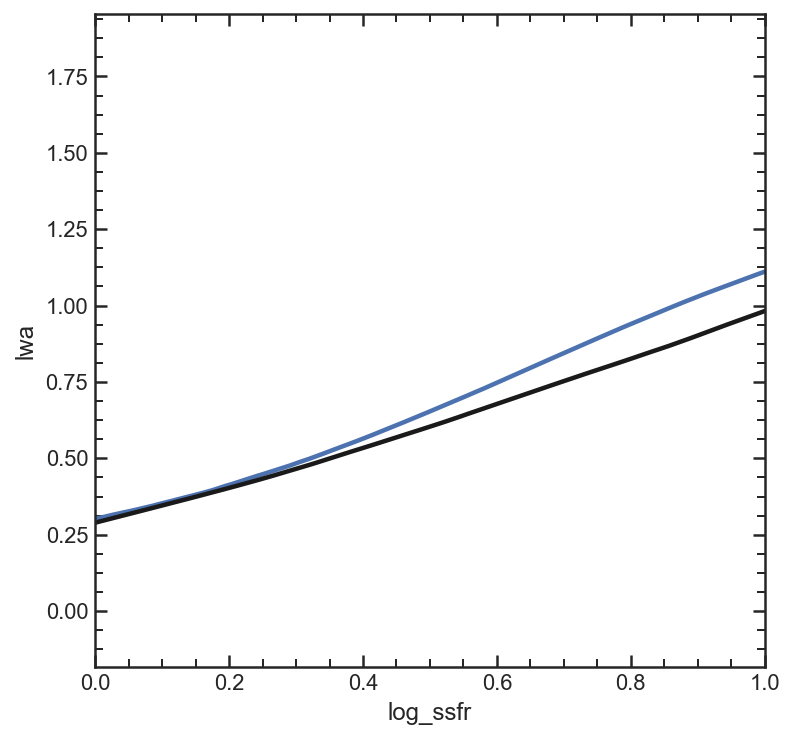

In [169]:
plt.figure(figsize=[6,6])
sea.regplot(np.log10(1/(10**adb.query('AGN != "AGN" and log_ssfr > -11').log_ssfr*1E9)),
                adb.query('AGN != "AGN" and log_ssfr > -11').lwa, color = 'b', lowess = True, scatter = False)
sea.regplot(np.log10(1/(10**adb.query('AGN == "AGN" and log_ssfr > -11').log_ssfr*1E9)),
                adb.query('AGN == "AGN" and log_ssfr > -11').lwa, color = 'k', marker = 'x', lowess = True, scatter = False)

# plt.yscale('log')
# plt.xlim(-1.2,2.2)
# plt.ylim(10**-2,10**1)

In [136]:
dres = np.load('../data/out_dict/GSD_18933_SFfit_p1.npy', allow_pickle = True).item()

In [141]:
from spec_id import *
from spec_id_2d import *

In [138]:
sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 1)

lwa = []
for i in range(len(dres.samples)):
    m, a, m1, m2, m3, m4, m5, m6, lm, d, bp1, rp1, ba, bb, bl, ra, rb, rl = dres.samples[i]
    lwa.append(get_lwa_SF([m, a, m1, m2, m3, m4, m5, m6], get_agebins(a, binnum=6),sp)[0])



t,pt = Get_derived_posterior(np.array(lwa), dres)
# np.save(pos_path + '{0}_{1}_tabMfit_Plwa'.format(field, galaxy),[t,pt])

fit_db = np.load('../data/posteriors/GSD_18933_SFfit_p1_fits.npy', allow_pickle=True).item()

fit_db['Plwa'] = pt
fit_db['lwa'] = t

#np.save('../data/posteriors/GSD_18933_SFfit_p1_fits.npy', fit_db, allow_pickle=True)

In [179]:
# age, SFR, log mass, redshift (also RA, DEC, of course)
N_bldg = pd.read_pickle('../dataframes/galaxy_frames/GN_buldge_insamp.pkl')
S_bldg = pd.read_pickle('../dataframes/galaxy_frames/GS_buldge_insamp.pkl')

In [185]:
adb = adb.reset_index()
adb = adb.drop(columns='index')


,AGN,Av,Av_hdr,Av_modality,Ra,Ra_f125,Ra_f125_sig,Ra_f160,Ra_f160_sig,Ra_nsig,...,z_80,z_80_hdr,z_80_modality,z_90,z_90_hdr,z_90_modality,zfit,zgrism,zgrism_hdr,zgrism_modality
0,-,0.466974,"[0.34248340237828345, 0.5865819906799938]",[0.0],0.151500,0.183792,0.006695,0.151500,0.004317,0.010063,...,2.942061,"[2.4988786985188916, 3.232416669148818]",[0.0],2.438663,"[2.18562532756868, 2.5601999534368347]",[0.0],1.7473,1.769793,"[1.737823543480748, 1.7864438910034974]",[0.0]
1,-,0.002145,"[0.002144540990419161, 0.1951023511583982]","[0.6007805552771712, 0.00890252193524415]",0.138888,0.138888,0.013096,0.139002,0.011056,0.015523,...,1.261166,"[1.1041228149076263, 1.3642409533481183]",[0.0],1.104605,"[0.9819751441996263, 1.1612298194405772]",[0.0],0.7875,0.845746,"[0.81592874714366, 0.8706959979257327]","[0.046464709601973506, 0.1943350151108464]"
2,-,0.454612,"[0.41118994718654833, 0.5034610756904888]",[0.0],0.397230,0.397230,0.003723,0.365946,0.002816,0.024123,...,2.087934,"[2.0255657318977085, 2.1471658336681183]",[0.0],1.832704,"[1.7628402187624908, 1.8824088696450059]",[0.0],1.3400,1.333095,"[1.3293190186710149, 1.3383820167162035]",[0.0]
3,-,0.002007,"[0.0020073329460341756, 0.05033693811218445]",[0.0],0.116604,0.116604,0.005110,0.121428,0.004502,0.008663,...,3.971097,"[2.954077867342775, 5.222357557781916]",[0.0],3.707464,"[2.869478196020569, 5.114862661618786]","[0.17544006343152457, 0.2331041224016785]",1.1193,1.119178,"[1.1045978653645228, 1.1326359347553807]",[0.0]
4,-,0.382130,"[0.2877833692593465, 0.476477274932741]",[0.3592797931879877],1.075130,1.051720,0.015512,1.075130,0.010293,0.065324,...,3.343026,"[2.6714549036457513, 3.871496297759869]",[0.0],2.743647,"[2.2941148358821604, 3.2250550742420336]",[0.0],1.5928,1.588635,"[1.5535920513895751, 1.5999724692667114]",[0.0873186433969917]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016,-,1.081686,"[1.0100855143898446, 1.1752052119370129]",[0.0],1.237450,1.237450,0.015251,1.064740,0.009753,NaN,...,2.253269,"[2.143727174613379, 2.305379410230458]",[0.0],1.939388,"[1.889026444179265, 1.9790682511021447]",[0.0],NaN,1.306369,NaN,NaN
1017,-,1.046551,"[0.9653823241950912, 1.1383994133898254]",[0.0],0.700242,0.700242,0.005650,0.661896,0.004514,NaN,...,1.628824,"[1.4090777479116405, 1.7997126457216244]",[0.0],1.364886,"[1.233669660692301, 1.4798840928834651]",[0.0],NaN,1.029317,NaN,NaN
1018,-,1.837140,"[1.7396538415357634, 1.9221803540549836]",[0.0],0.269262,0.380004,0.014600,0.269262,0.005673,NaN,...,2.110213,"[2.100297900846552, 2.1172304616016215]",[0.0],2.096023,"[2.0876342963000196, 2.099138542037803]",[0.0],NaN,2.050221,NaN,NaN
1019,-,1.691777,"[1.579951275151303, 1.7744980876541736]",[0.0],0.480528,0.480528,0.003160,0.444444,0.002484,NaN,...,1.178952,"[1.0635628950110403, 1.2366526212297577]",[0.0],0.971573,"[0.9027218905750489, 0.9908358511127681]",[0.0],NaN,0.841412,NaN,NaN


In [188]:
inout = []
for i in adb.index:
    IO = 'o'
    if adb.field[i] == 'GND' and adb.id[i] in N_bldg.id.values:
        IO = 'i' 
    if adb.field[i] == 'GSD' and adb.id[i] in S_bldg.id.values:
        IO = 'i' 
    inout.append(IO)
    
adb['inout'] = inout

In [191]:
bldg = []
for i in adb.index:
    IO = 'o'
    if adb.inout[i] == 'i':
        IO = 'i'
    if adb.inout[i] == 'o' and adb.log_ssfr[i] > -11:
        IO = 'i'
    bldg.append(IO)
    
adb['bldg'] = bldg

In [208]:
gnd_cat = Table.read('/Users/Vince.ec/catalogs_for_CLEAR/goodsn_3dhst.v4.1.cats/Catalog/goodsn_3dhst.v4.1.cat', 
                     format = 'ascii').to_pandas()
gsd_cat = Table.read('/Users/Vince.ec/catalogs_for_CLEAR/goodss_3dhst.v4.1.cats/Catalog/goodss_3dhst.v4.1.cat', 
                     format = 'ascii').to_pandas()

In [224]:
field = []
gid = []
t50 = []
lwa = []
SFR = []
lmass = []
rshift = []
ra = []
dec = []
# age, SFR, log mass, redshift (also RA, DEC, of course)
for i in adb.index:  
    field.append(adb.field[i])
    gid.append(adb.id[i])
    t50.append(adb.t_50[i])
    lwa.append(adb.lwa[i])
    SFR.append(10**adb.log_ssfr[i] * 10**adb.lmass[i])
    lmass.append(adb.lmass[i])
    if adb.zgrism[i] > 0:
        rshift.append(adb.zgrism[i])
    else:
        rshift.append(adb.zfit[i])
        
    if adb.field[i] == 'GND':
        ra.append(gnd_cat.query('id == {}'.format(adb.id[i])).ra.values[0])
        dec.append(gnd_cat.query('id == {}'.format(adb.id[i])).dec.values[0])

    if adb.field[i] == 'GSD':
        ra.append(gsd_cat.query('id == {}'.format(adb.id[i])).ra.values[0])
        dec.append(gsd_cat.query('id == {}'.format(adb.id[i])).dec.values[0])


# sea.distplot(adb.query('inout == "i" and bldg == "i"').log_ssfr)
# sea.distplot(adb.query('inout == "o" and bldg == "i"').log_ssfr)

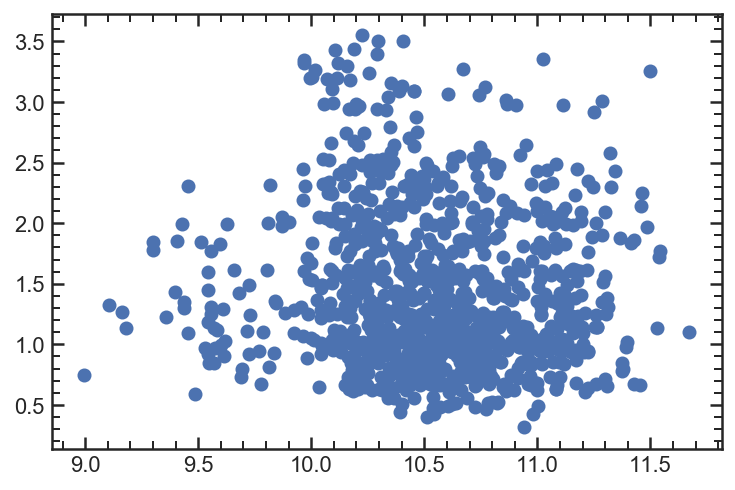

In [230]:
plt.scatter(lmass, rshift)

In [231]:
Bdb = pd.DataFrame({'field' : field, 'id' : gid, 't50' : t50, 'lwa' : lwa, 
                    'SFR' : SFR, 'logmass' : lmass, 'redshift' : rshift, 'ra' : ra, 'dec' : dec})

In [232]:
Bdb = Bdb[['field', 'id', 't50', 'lwa', 'SFR', 'logmass', 'redshift', 'ra', 'dec']]

In [233]:
Bdb.to_pickle('../dataframes/fitdb/bulge_dominated_updated_catalog.pkl')

In [234]:
Bdb

,field,id,t50,lwa,SFR,logmass,redshift,ra,dec
0,GSD,35640,2.457341,1.251232,1.452676,10.627360,1.769793,53.197034,-27.745610
1,GND,37281,3.261248,1.686809,0.019705,9.568852,0.845746,189.252204,62.350149
2,GSD,40862,2.725779,1.757985,2.119482,11.114971,1.333095,53.048020,-27.719743
3,GND,35835,4.244692,3.849416,0.013380,10.188976,1.119178,189.212077,62.332126
4,GSD,26272,3.137022,1.770484,0.214307,10.745344,1.588635,53.150826,-27.790601
...,...,...,...,...,...,...,...,...,...
1016,GSD,35444,3.309895,2.095117,3.641608,11.310489,1.306369,53.172859,-27.744457
1017,GND,37525,3.772565,1.410073,7.866388,10.929155,1.029317,189.309988,62.356479
1018,GND,30898,0.206371,0.188392,20.500812,11.069196,2.050221,189.153107,62.296589
1019,GND,32427,3.416990,0.803289,16.155508,10.788968,0.841412,189.320109,62.306720
